Подключаем пакеты

In [11]:
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numba import cuda
import numba
import math
import time
from pycuda import tools

tools.make_default_context().get_device().name()

'NVIDIA GeForce RTX 3050 Laptop GPU'

Пишем функцию для подготовки изображений

In [2]:
def add_salt_and_pepper(gb, prob):
  rnd = np.random.rand(gb.shape[0], gb.shape[1])
  noisy = gb.copy()
  noisy[rnd < prob] = 0
  noisy[rnd > 1 - prob] = 255
  return noisy

Пишем функции для обработки изображения на CPU

In [3]:
def median_filter(a):
  b = a.copy()
  start = time.time()
  for i in range(2, len(a) - 1):
    for j in range(2, len(a[i]) - 1):
      t = [
           a[i - 1][j - 1], a[i - 1][j],  a[i - 1][j + 1], 
           a[i][j - 1],   a[i][j],    a[i][j + 1], 
           a[i + 1][j - 1], a[i + 1][j],  a[i + 1][j + 1]
           ]
      for k in range(8):
        for l in range(8 - k):
          if t[l] > t[l + 1]:
            t[l], t[l + 1] = t[l + 1], t[l]
      b[i][j] = t[int(len(t) / 2)]
  return time.time() - start

# Функция для вывода обработанного изображения
def img_gpu(a):
  b = a.copy()
  for i in range(2, len(a) - 1):
    for j in range(2, len(a[i]) - 1):
      t = [
           a[i - 1][j - 1], a[i - 1][j],  a[i - 1][j + 1], 
           a[i][j - 1],   a[i][j],    a[i][j + 1], 
           a[i + 1][j - 1], a[i + 1][j],  a[i + 1][j + 1]
           ]
      for k in range(8):
        for l in range(8 - k):
          if t[l] > t[l + 1]:
            t[l], t[l + 1] = t[l + 1], t[l]
      b[i][j] = t[int(len(t) / 2)]
  return b

Пишем функцию для обработки изображения на GPU

In [4]:
@cuda.jit
def gpu_median_filter(a, b):
  i, j = cuda.grid(2)
  t=cuda.local.array(shape=9, dtype=numba.int64)
  t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8] = a[i - 1][j - 1], a[i - 1][j], a[i - 1][j + 1], a[i][j - 1], a[i][j], a[i][j + 1], a[i + 1][j - 1], a[i + 1][j], a[i + 1][j + 1]
  for k in range(8):
    for l in range(8 - k):
      if t[l] > t[l + 1]:
        t[l], t[l + 1] = t[l + 1], t[l]
  b[i][j] = t[int(len(t) / 2)]
    
def prepare_and_exec_gpu(a):
  b = a.copy()
  tread_number_block = 32

  a_global = cuda.to_device(a)
  b_global = cuda.to_device(b)
    
  threadsperblock = (tread_number_block, tread_number_block)
  blockspergrid_x = int(math.ceil(a.shape[0] / threadsperblock[1]))
  blockspergrid_y = int(math.ceil(b.shape[1] / threadsperblock[0]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  start = time.time()
  gpu_median_filter[blockspergrid, threadsperblock](a_global, b_global)
  return  time.time() - start

Сохраняем исходное изображение в ЧБ

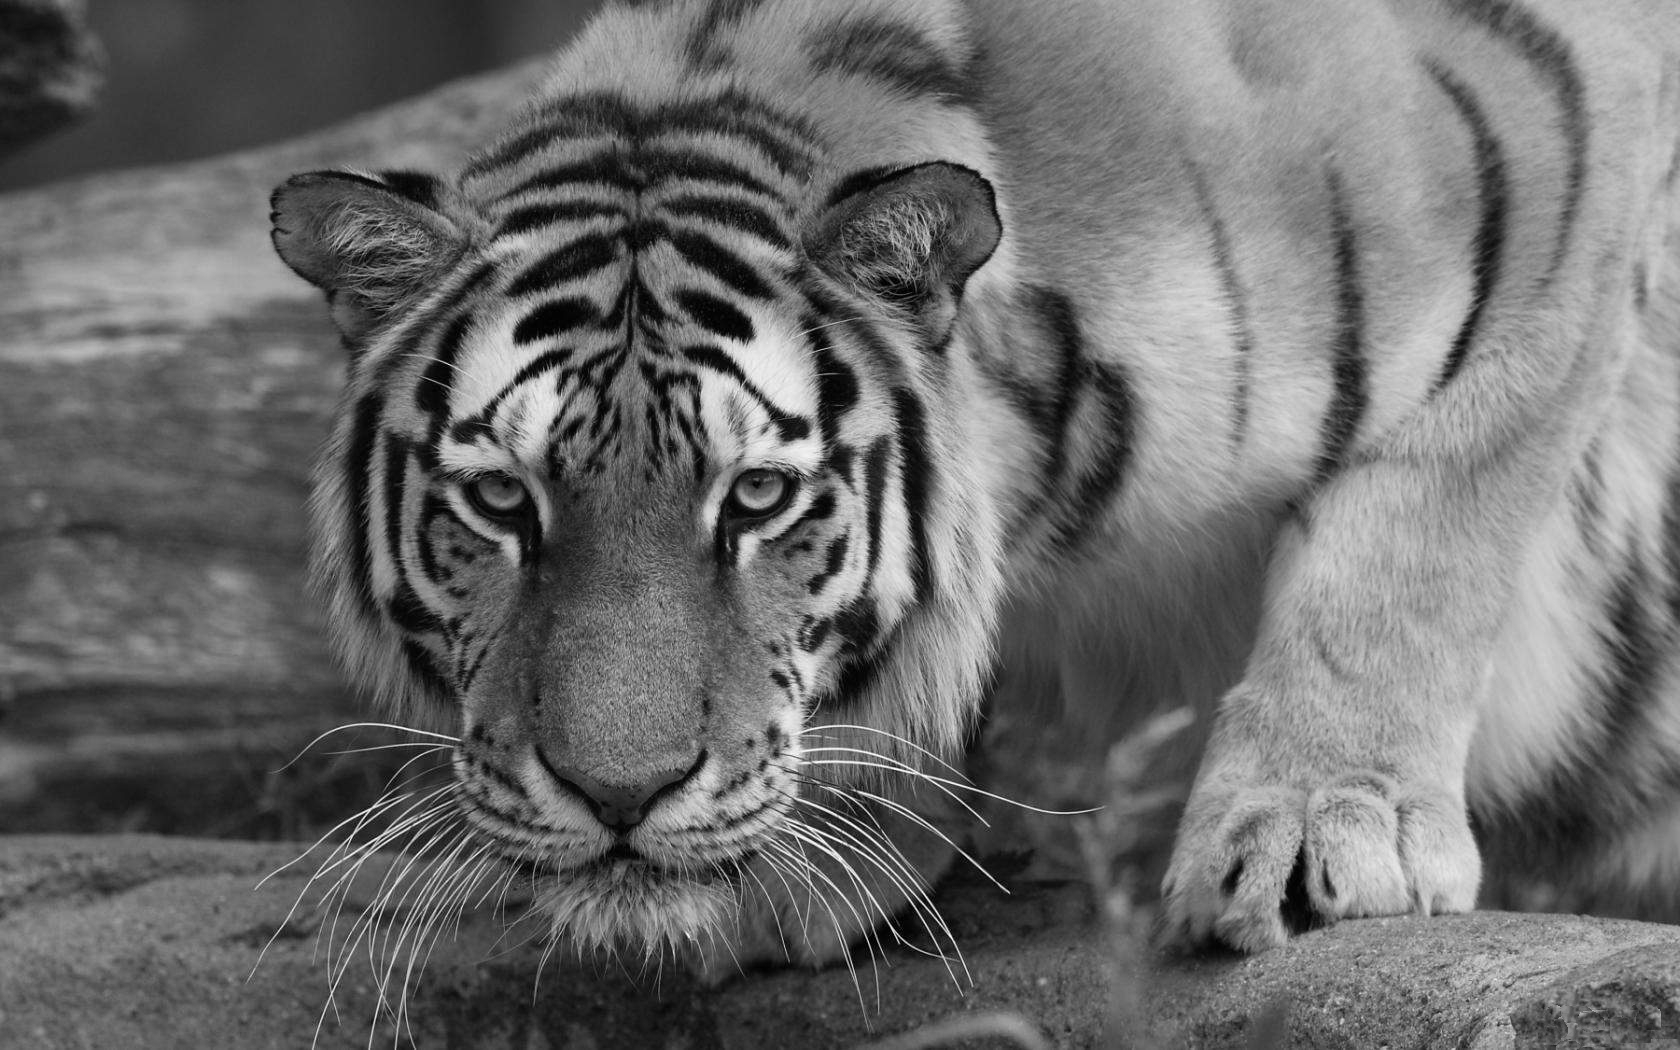

In [5]:
img = (Image.open("./img/tiger.bmp")).convert('L')
display(img)
width, height = img.size
ratio = height / width
img = np.array(img)
img = add_salt_and_pepper(img, 0.02)

Добавляем "соль/перец" и создаем изображения в других размерностях

In [6]:
Image.fromarray(np.uint8(img)).save("./img/tiger_nois.bmp")

img = (Image.open("./img/tiger.bmp")).convert('L')
img_nois = (Image.open("./img/tiger_nois.bmp")).convert('L')
def resz(i):
  newheight = round(ratio * i)
  return img_nois.resize((i, newheight), Image.ANTIALIAS)

sizes = [1200,1000,800,500,250] # Доп. разрешения файлов

for k in sizes:
  new_img = resz(k)
  Image.fromarray(np.uint8(new_img)).save("./img/tiger_nois" + str(k) + ".bmp") # Создаем доп размеры

C:\Users\Bogda\AppData\Local\Temp\ipykernel_15496\1086980258.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  return img_nois.resize((i, newheight), Image.ANTIALIAS)


Пример возврата обработанного изображения на GPU

Пример изображения разрешения 800 с количеством элементов:  400000


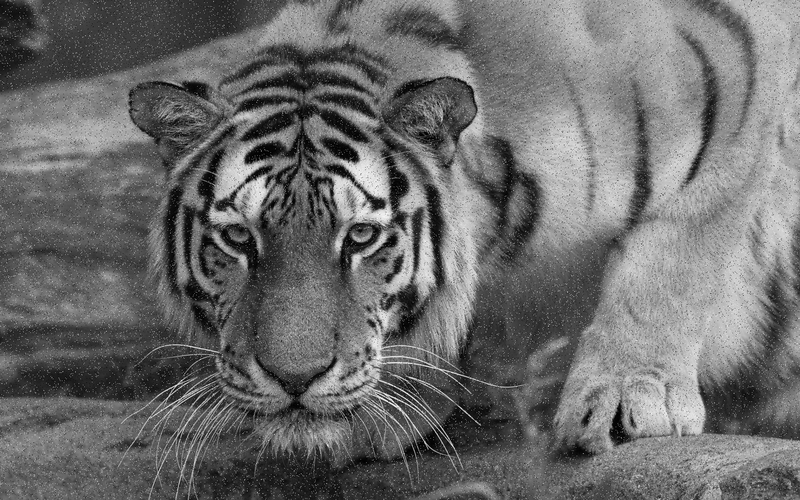

Изображение этой же размерности, но после обработки на CPU


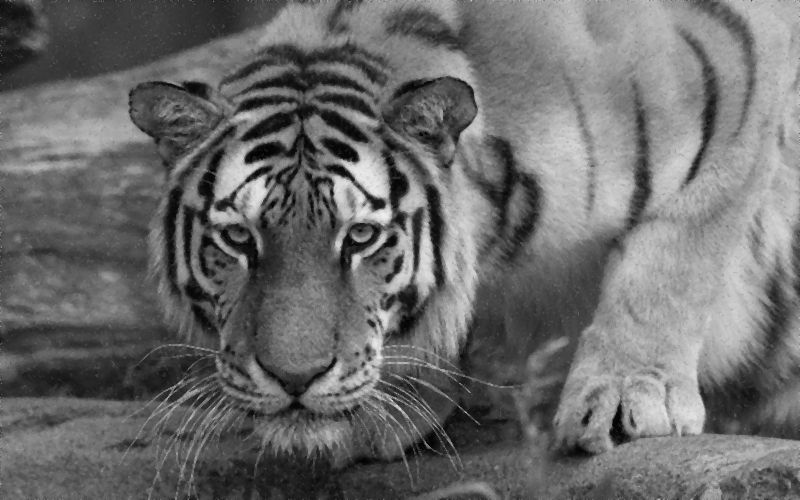

In [7]:
img = Image.open("./img/tiger_nois800.bmp")
img2 = np.array(img)
n = len(img2) * len(img2[0])
print('Пример изображения разрешения 800 с количеством элементов: ', n)
display(img)
img2 = img_gpu(img2)
print('Изображение этой же размерности, но после обработки на CPU')
display(Image.fromarray(np.uint8(img2)))

Циклом обрабатываем изображения на CPU и GPU используя функцию медианного фильтра

In [8]:
import glob

IMAGE_DIR = "./img"
image_files = glob.glob('./img/tiger_nois*.bmp')
image_files.sort(key=len)

data_dict = {
    "file": [],
    "shape": [],
    "time_cpu, s": [],
    "time_gpu, s": []
}

for file_path in image_files:
    image = np.array(Image.open(file_path).convert("L"))
    data_dict["file"].append(file_path)
    data_dict["shape"].append(image.shape[0] * image.shape[1])
    data_dict["time_cpu, s"].append(median_filter(image))
    data_dict["time_gpu, s"].append(prepare_and_exec_gpu(image))

c:\Users\Bogda\anaconda3\envs\ml\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Попытка заполнить пустые данные по GPU (в цикле так же возвращаются 0 для недостающих значений)

data_dict_gpu = {
    "file": [],
    "shape": [],
    "time_gpu, s": []
}

data_dict_gpu['file']          = data_dict['file']          
data_dict_gpu['shape']         = data_dict['shape']         
data_dict_gpu['time_gpu, s']   = data_dict['time_gpu, s']   

res_ind = [i for i,v in enumerate(data_dict_gpu['time_gpu, s']) if v == 0]
res_ind

data_dict_gpu = {
    "file": [],
    "shape": [],
    "time_gpu, s": []
}

data_dict_gpu['file']          = data_dict['file']          
data_dict_gpu['shape']         = data_dict['shape']         
data_dict_gpu['time_gpu, s']   = data_dict['time_gpu, s']   

res = len([i for i,v in enumerate(data_dict_gpu['time_gpu, s']) if v == 0])

while res > 0 :    
    res_ind = [i for i,v in enumerate(data_dict_gpu['time_gpu, s']) if v == 0]
    res = len(res_ind)
    res_list = [data_dict_gpu['file'][i] for i in res_ind]
    data_dict_gpu["file"]        = [data_dict_gpu["file"][index] for index in res_ind]
    data_dict_gpu["shape"]       = [data_dict_gpu["shape"][index] for index in res_ind]
    data_dict_gpu["time_gpu, s"] = [data_dict_gpu["time_gpu, s"][index] for index in res_ind]

    for file_path in res_list:
        image = np.array(Image.open(file_path).convert("L"))
        gpu_time = prepare_and_exec_gpu(image)
        if gpu_time > 0:
            data_dict_gpu["time_gpu, s"].append(gpu_time)
            data_dict_gpu["file"].append(file_path)
            data_dict_gpu["shape"].append(image.shape[0] * image.shape[1])
            break        
          
    print(len(res_ind))
    time.sleep(10)

Формируем датафрейм из данных по времени выполнения обработки изображений на CPU и GPU

In [9]:
df = pd.DataFrame(data=data_dict)
df["boost"] = df["time_cpu, s"] / df["time_gpu, s"]
df = df.sort_values('shape')
df = df[np.isfinite(df.boost)]
df

,file,shape,"time_cpu, s","time_gpu, s",boost
2,./img\tiger_nois500.bmp,156000,1.442191,0.000991,1454.783309
0,./img\tiger_nois.bmp,1764000,16.210769,0.493988,32.816101


Выводы

При уменьшении разрешения файла уменьшается ускорение в обработке изображения на GPU относительно CPU
Так для изображения размерностью: 156000.0  ускорение составляло 1454.8 раза
а для размерности в: 1764000.0 уже всего 32.8 раза
Однако даже такое ускорение обработки файлов можно считать существенным если задача будет стоять в обработке большого числа изображений
учитывая что среднее время обработки изображений на CPU составляет  8.8 сек.  а среднее время обработки на GPU всего: 0.2 сек.


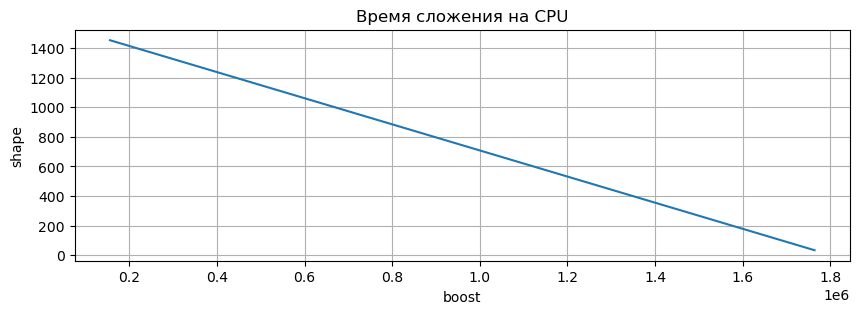

In [10]:
plt.figure(figsize=(10,3))
plt.title("Время сложения на CPU")
plt.plot(df['shape'], df['boost'])
plt.xlabel("boost")
plt.ylabel("shape")
plt.grid()

min_df = df[df['shape']==min(df['shape'])]
max_df = df[df['shape']==max(df['shape'])]

print('При уменьшении разрешения файла уменьшается ускорение в обработке изображения на GPU относительно CPU')
print('Так для изображения размерностью:', f"{ max(min_df['shape']):.{1}f}",' ускорение составляло ' f"{ max(min_df['boost']):.{1}f}",'раза')
print('а для размерности в:', f"{ max(max_df['shape']):.{1}f}", "уже всего "  f"{ max(max_df['boost']):.{1}f}",'раза')
print('Однако даже такое ускорение обработки файлов можно считать существенным если задача будет стоять в обработке большого числа изображений') 
print('учитывая что среднее время обработки изображений на CPU составляет ', f"{ np.mean(df['time_cpu, s']):.{1}f}","сек. ", "а среднее время обработки на GPU всего: " f"{ np.mean(df['time_gpu, s']):.{1}f}","сек.") 